<a href="https://colab.research.google.com/github/sharlynmuturi/Pytorch-Tutorial/blob/main/insurance_fraud_ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score, precision_recall_curve,
    auc, roc_curve, average_precision_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files

uploaded = files.upload()

Saving fraud_oracle.csv to fraud_oracle.csv


In [69]:
data = pd.read_csv('fraud_oracle.csv')

In [70]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

#  Data Exploration

In [71]:
data.isnull().values.any()

np.False_

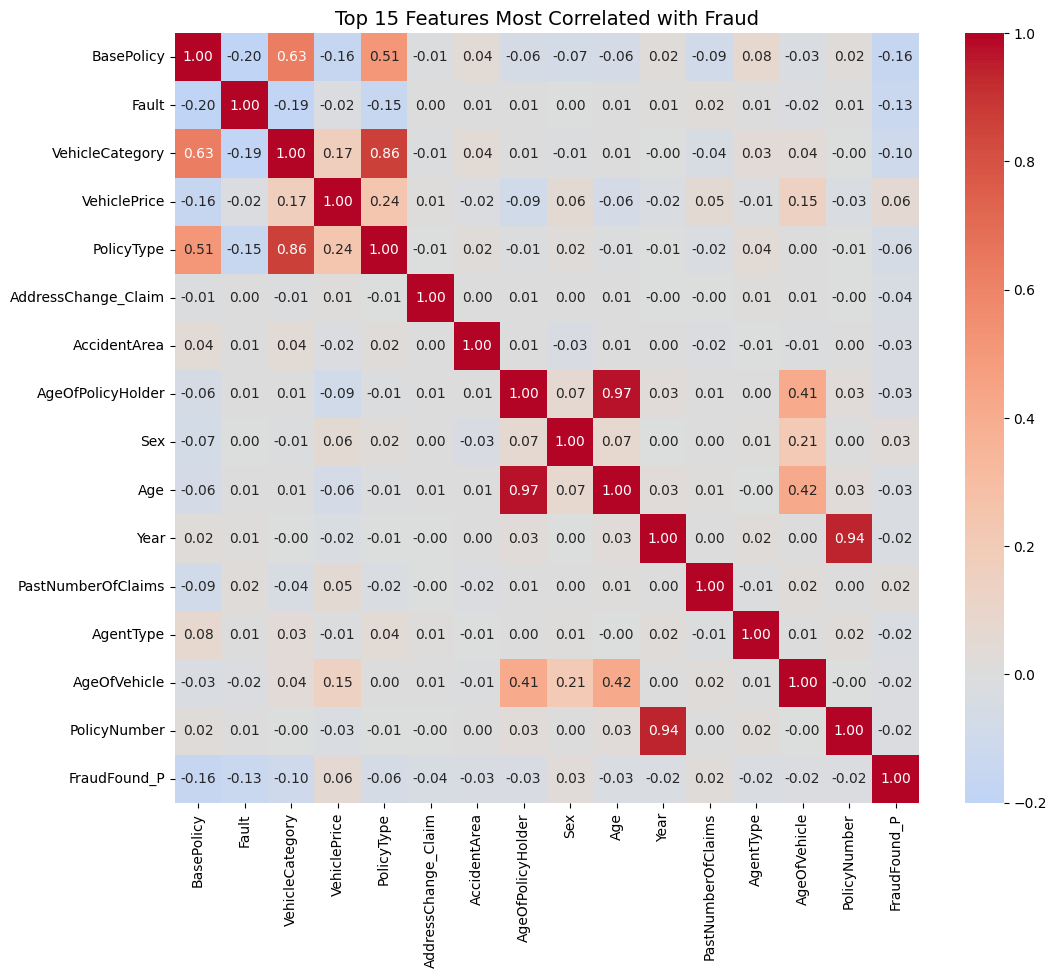

In [72]:
data_encoded = data.copy()

for col in data_encoded.select_dtypes(include=['object', 'category']):
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col])

corr_with_class = data_encoded.corr()['FraudFound_P']

top_features = corr_with_class.abs().sort_values(ascending=False).iloc[1:16].index.tolist()
top_features.append('FraudFound_P')

plt.figure(figsize=(12, 10))
sns.heatmap(data_encoded[top_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Top 15 Features Most Correlated with Fraud", fontsize=14)
plt.show()

## Train-Test Split

In [73]:
X = data.drop(columns='FraudFound_P', axis=1)
y = data['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(15420, 32) (12336, 32) (3084, 32)


## Encoding and Scaling

In [74]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing for numeric: center & scale
numeric_transformer = StandardScaler()

# Preprocessing for categorical: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first')

# Combining transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fitting the transformer on training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transforming test data
X_test_processed = preprocessor.transform(X_test)


## Data Balancing

In [75]:
smote = SMOTE(sampling_strategy=0.5, random_state=123)  # p = 0.5 ~ 50% fraud
X_train_processed, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

# Model Training
## Ensemble with Soft Voting

In [76]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = xgb.XGBClassifier(scale_pos_weight=10, random_state=42)
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb_model), ('lgb', lgb_model)],
    voting='soft',
    weights=[2, 1, 1, 1]  # giving more weight to LR for higher recall
)


ensemble.fit(X_train_processed, y_train_balanced)

# Predictions
y_pred = ensemble.predict(X_test_processed)
y_pred_proba = ensemble.predict_proba(X_test_processed)[:, 1]  # probability of class 1 (fraud)

# Metrics
pr_auc = average_precision_score(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2899
           1       0.49      0.51      0.50       185

    accuracy                           0.94      3084
   macro avg       0.73      0.74      0.73      3084
weighted avg       0.94      0.94      0.94      3084

Confusion Matrix:
 [[2799  100]
 [  90   95]]
ROC-AUC: 0.9011
PR-AUC: 0.4920
